In [20]:
import os
import ast
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import optimizers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
def drawing_to_np(drawing, shape=(28, 28)):
    # evaluates the drawing array
    drawing = eval(drawing)
    fig, ax = plt.subplots()
    for x,y in drawing:
        ax.plot(x, y, marker='.')
        ax.axis('off')        
    fig.canvas.draw()
    # Close figure so it won't get displayed while transforming the set
    plt.close(fig)
    # Convert images to numpy array
    np_drawing = np.array(fig.canvas.renderer._renderer)
    # Take only one channel
    np_drawing =np_drawing[:, :, 1]    
    # Normalize data
    np_drawing = np_drawing / 255.
    return cv2.resize(np_drawing, shape) # Resize array


def plot_metrics_primary(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20,7))

    ax1.plot(acc, label='Train Accuracy')
    ax1.plot(val_acc, label='Validation accuracy')
    ax1.legend(loc='best')
    ax1.set_title('Accuracy')

    ax2.plot(loss, label='Train loss')
    ax2.plot(val_loss, label='Validation loss')
    ax2.legend(loc='best')
    ax2.set_title('Loss')

    plt.xlabel('Epochs')
    
    
def plot_confusion_matrix(cnf_matrix, labels): 
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
    plt.figure(figsize=(20,7))
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
    plt.show()

In [9]:
import os
import pandas as pd
from sklearn.utils import shuffle

TRAIN_PATH = '/kaggle/input/quickdraw-doodle-recognition/train_simplified'
TEST_PATH = '/kaggle/input/quickdraw-doodle-recognition/test_simplified.csv'
SUBMISSION_NAME = 'submission.csv'

# Initialize an empty list to store DataFrames
train_dfs = []

# Read first 5 files with 2000 rows each
for file in os.listdir(TRAIN_PATH)[:5]:
    df = pd.read_csv(os.path.join(TRAIN_PATH, file), usecols=[1, 5], nrows=2000)
    train_dfs.append(df)

# Concatenate all DataFrames
train = pd.concat(train_dfs, axis=0)

# Shuffle data
train = shuffle(train, random_state=123)

# Read test data
test = pd.read_csv(TEST_PATH, usecols=[0, 2], nrows=100)

In [10]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 60
LEARNING_RATE = 0.001
N_CLASSES = train['word'].nunique()
HEIGHT = 28
WIDTH = 28
CHANNEL = 1

In [11]:
print('Train set shape: ', train.shape)
print('Train set features: %s' % train.columns.values)
print('Train number of label categories: %s' % N_CLASSES)
train.head()

Train set shape:  (10000, 2)
Train set features: ['drawing' 'word']
Train number of label categories: 5


,drawing,word
656,"[[[47, 47], [150, 150]], [[47, 40, 23, 8, 1, 1...",rhinoceros
445,"[[[0, 1, 16, 46, 50, 21, 2], [7, 69, 73, 74, 2...",traffic light
1505,"[[[127, 3, 2, 7, 0, 1, 117, 252, 244, 246, 226...",van
332,"[[[3, 6, 12, 14, 22, 20, 6, 0, 1, 30, 51, 53, ...",traffic light
168,"[[[4, 0], [26, 88]], [[0, 2], [61, 42]], [[5, ...",bed


In [12]:
#Fixing labels.
train['word'] = train['word'].replace(' ', '_', regex=True)
# Get labels and one-hot encode them.
classes_names = train['word'].unique()
labels = pd.get_dummies(train['word']).values
train.drop(['word'], axis=1, inplace=True)
# Transform drawing into numpy arrays
train['drawing_np'] = train['drawing'].apply(drawing_to_np)
# Reshape arrays
train_drawings = np.asarray([x.reshape(HEIGHT, WIDTH, CHANNEL) for x in train['drawing_np'].values])

In [13]:
train.head()

,drawing,drawing_np
656,"[[[47, 47], [150, 150]], [[47, 40, 23, 8, 1, 1...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
445,"[[[0, 1, 16, 46, 50, 21, 2], [7, 69, 73, 74, 2...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1505,"[[[127, 3, 2, 7, 0, 1, 117, 252, 244, 246, 226...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
332,"[[[3, 6, 12, 14, 22, 20, 6, 0, 1, 30, 51, 53, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
168,"[[[4, 0], [26, 88]], [[0, 2], [61, 42]], [[5, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [14]:
x_train, x_val, y_train, y_val = train_test_split(train_drawings, labels, test_size=0.1, random_state=1)

In [22]:

def unet_based_model(input_shape=(HEIGHT, WIDTH, CHANNEL), n_classes=N_CLASSES):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Downsampling path (Encoder)
    # Block 1
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)
    
    # Block 2
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.25)(pool2)
    
    # Block 3 (Bottleneck)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    
    # Upsampling path (Decoder) with skip connections
    # Block 4
    up4 = UpSampling2D((2, 2))(conv3)
    up4 = concatenate([up4, conv2], axis=-1)
    up4 = Dropout(0.25)(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    
    # Block 5
    up5 = UpSampling2D((2, 2))(conv4)
    up5 = concatenate([up5, conv1], axis=-1)
    up5 = Dropout(0.25)(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    
    # Classification head
    gap = GlobalAveragePooling2D()(conv5)
    
    # Fully connected layers
    dense1 = Dense(256, activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    
    # Output layer
    outputs = Dense(n_classes, activation='softmax')(dense1)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = unet_based_model()

In [23]:
print('Dataset size: %s' % train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: (%s, %s, %s)' % (HEIGHT, WIDTH, CHANNEL))

model.summary()

Dataset size: 10000
Epochs: 60
Learning rate: 0.001
Batch size: 64
Input dimension: (28, 28, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 28, 28,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 28, 28,    │      9,248 │ conv2d_22[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 14, 14,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 14, 14,    │          0 │ max_pooling2d_4[… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 14, 14,    │     18,496 │ dropout_10[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_24[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 7, 7, 64)  │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 7, 7, 64)  │          0 │ max_pooling2d_5[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 7, 7, 128) │     73,856 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 7, 7, 128) │    147,584 │ conv2d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 14, 14,    │          0 │ conv2d_27[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 14, 14,    │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 192)              │            │ conv2d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 14, 14,    │          0 │ concatenate_4[0]… │
│ (Dropout)           │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 14, 14,    │    110,656 │ dropout_12[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_28[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 28, 28,    │          0 │ conv2d_29[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 480,677 (1.83 MB)

 Trainable params: 480,677 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val))

Epoch 1/60


I0000 00:00:1755110538.424085      99 service.cc:148] XLA service 0x79a8280022c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755110538.424714      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755110539.039108      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 16/141 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1909 - loss: 1.6101

I0000 00:00:1755110545.025104      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.2017 - loss: 1.6099 - val_accuracy: 0.2000 - val_loss: 1.6098
Epoch 2/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1931 - loss: 1.6099 - val_accuracy: 0.2000 - val_loss: 1.6095
Epoch 3/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1982 - loss: 1.6095 - val_accuracy: 0.2000 - val_loss: 1.6096
Epoch 4/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2038 - loss: 1.6095 - val_accuracy: 0.1860 - val_loss: 1.6096
Epoch 5/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1944 - loss: 1.6097 - val_accuracy: 0.2020 - val_loss: 1.6096
Epoch 6/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1867 - loss: 1.6102 - val_accuracy: 0.1860 - val_loss: 1.6095
Epoch 7/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1892 - loss: 1.6098 - val_accuracy: 0.1860 - val_loss: 1.6096
Epoch 8/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2030 - loss: 1.6094 - val_accuracy: 0.18

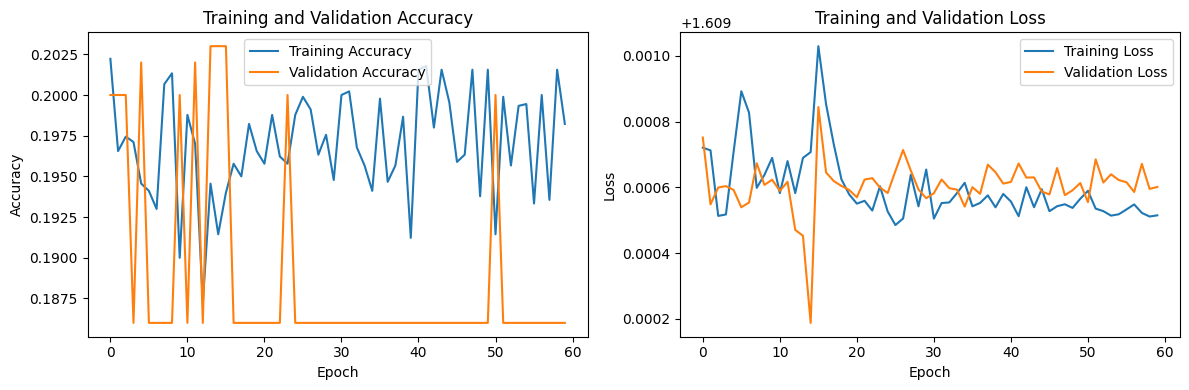

In [26]:
def plot_metrics_primary(train_accuracy, val_accuracy, train_loss, val_loss):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function with the correct keys
plot_metrics_primary(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    history.history['loss'], 
    history.history['val_loss']
)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


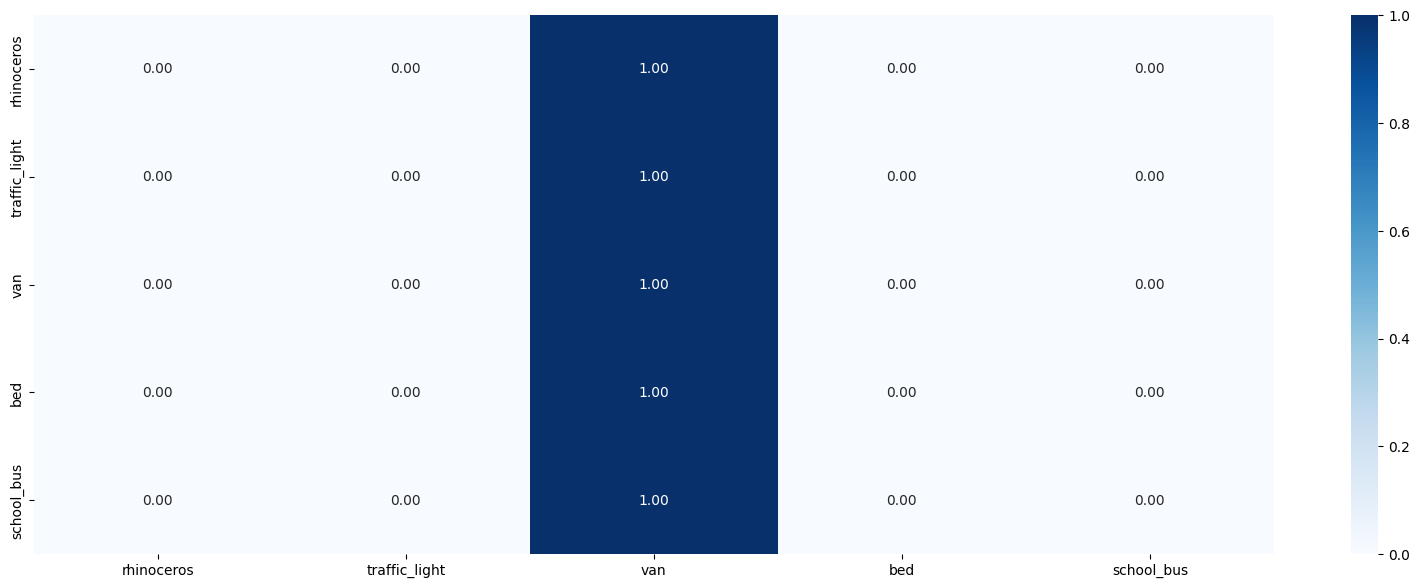

In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions
y_pred = model.predict(x_val)  # Get probability predictions
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class predictions
y_true = np.argmax(y_val, axis=1)  # Convert one-hot encoded y_val to class indices

# Generate confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plot_confusion_matrix(cnf_matrix, classes_names)

In [30]:
# Transform drawing into numpy arrays.
test['drawing_np'] = test['drawing'].apply(drawing_to_np)
# Reshape arrays.
test_drawings = np.asarray([x.reshape(HEIGHT, WIDTH, CHANNEL) for x in test['drawing_np'].values])

In [31]:
predictions = model.predict(test_drawings)
top_3_predictions = np.asarray([np.argpartition(pred, -3)[-3:] for pred in predictions])
top_3_predictions = ['%s %s %s' % (classes_names[pred[0]], classes_names[pred[1]], classes_names[pred[2]]) for pred in top_3_predictions]
test['word'] = top_3_predictions

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


In [32]:
submission = test[['key_id', 'word']]
submission.to_csv(SUBMISSION_NAME, index=False)
submission.head(10)

,key_id,word
0,9000003627287624,school_bus rhinoceros van
1,9000010688666847,school_bus rhinoceros van
2,9000023642890129,school_bus rhinoceros van
3,9000038588854897,school_bus rhinoceros van
4,9000052667981386,school_bus rhinoceros van
5,9000057427034623,school_bus rhinoceros van
6,9000065506980882,school_bus rhinoceros van
7,9000087586309806,school_bus rhinoceros van
8,9000092580281382,school_bus rhinoceros van
9,9000096661653918,school_bus rhinoceros van
